In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import lib_utils
from data import data_utils
from nets import utils
from nets import mobilenet_v2 as mobilenet
from nets import mobilenet_v2_140 as mobilenet_140

In [2]:
dataset_type = 'orchids52_v1_tf'
model_name = 'mobilenet_v2_140'
batch_size = 32
learning_rate = 0.004
optimizer = 'rmsprop'
exp_decay = False
train_step = 1
num_classes = 52
training = True

In [3]:
workspace_path = os.environ["WORKSPACE"] if "WORKSPACE" in os.environ else "/Volumes/Data/tmp"
data_path = os.environ["DATA_DIR"] if "DATA_DIR" in os.environ else "/Users/watcharinsarachai/Documents/_datasets/"
data_dir = os.path.join(data_path, "orchids52_data")

In [4]:
print (data_dir)

/Users/watcharinsarachai/Documents/_datasets/orchids52_data


In [5]:
load_dataset = data_utils.dataset_mapping[dataset_type]
create_model = utils.nets_mapping[model_name]
checkpoint_path = os.path.join(workspace_path, "orchids-models", "orchids2019", model_name)

In [6]:
print (checkpoint_path)

/Users/watcharinsarachai/tmp/orchids-models/orchids2019/mobilenet_v2_140


In [7]:
if not tf.io.gfile.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

In [8]:
train_ds = load_dataset(split="train", batch_size=batch_size, root_path=data_dir)
test_ds = load_dataset(split="test", batch_size=batch_size, root_path=data_dir)

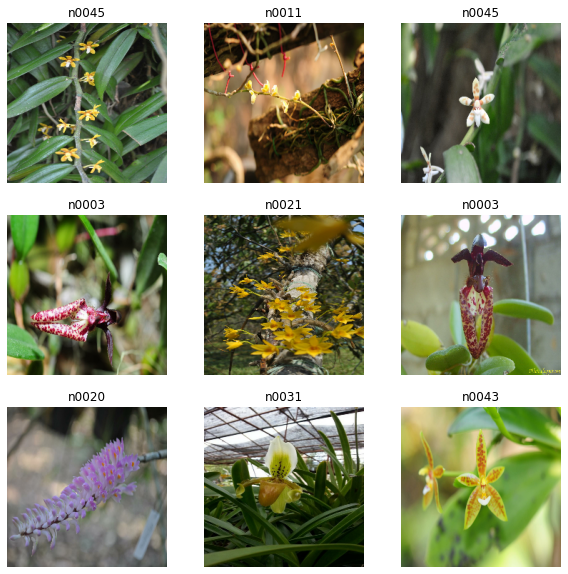

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        label = tf.argmax(labels[i], axis=0)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.classes[label][0])
        plt.axis("off")

In [10]:
training_step = utils.TRAIN_TEMPLATE.format(step=train_step)

In [11]:
learning_rate = lib_utils.config_learning_rate(learning_rate=learning_rate, exp_decay=exp_decay, training_step=training_step)
learning_rate

0.004

In [12]:
optimizer = lib_utils.config_optimizer(optimizer, learning_rate=learning_rate, training_step=training_step)

In [13]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [14]:
base_model = mobilenet.create_mobilenet_v2(input_shape=mobilenet.IMG_SHAPE_224, alpha=1.4, include_top=False, weights="imagenet", sub_name="01")
base_model.trainable = False

In [15]:
base_model.summary()

Model: "mobilenetv2_01_1.40_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mobilenetv2_01_1.40_224_input ( [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
mobilenetv2_01_1.40_224_Conv1_p (None, 225, 225, 3)  0           mobilenetv2_01_1.40_224_input[0][
__________________________________________________________________________________________________
mobilenetv2_01_1.40_224_Conv1 ( (None, 112, 112, 48) 1296        mobilenetv2_01_1.40_224_Conv1_pad
__________________________________________________________________________________________________
mobilenetv2_01_1.40_224_bn_Conv (None, 112, 112, 48) 192         mobilenetv2_01_1.40_224_Conv1[0][
____________________________________________________________________________

In [16]:
preprocess_layer = mobilenet_140.PreprocessLayer()
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
inputs = tf.keras.Input(shape=mobilenet.IMG_SHAPE_224)
prediction_layer = mobilenet_140.PredictionLayer(num_classes=num_classes, shape=[1, 7, 7], activation="softmax")

In [17]:
processed_inputs = preprocess_layer(inputs, training=training)
rescale_inputs = rescale(processed_inputs)
mobilenet_logits = base_model(rescale_inputs, training=training)
outputs = prediction_layer(mobilenet_logits, training=training)

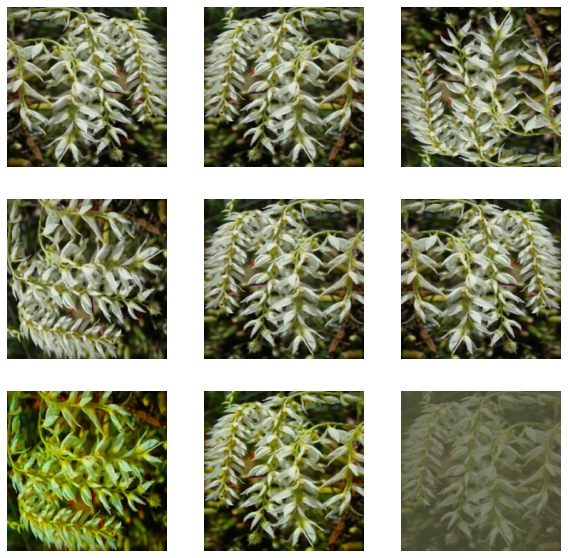

In [18]:
_model = tf.keras.Model(inputs, processed_inputs)
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = _model(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image.numpy().astype("uint8")[0])
        plt.axis('off')

In [19]:
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
preprocess_layer (Preprocess (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_01_1.40_224 (Fun (None, 7, 7, 1792)        4363712   
_________________________________________________________________
prediction_layer (Prediction (None, 52)                93236     
Total params: 4,456,948
Trainable params: 93,236
Non-trainable params: 4,363,712
_________________________________________________________________


In [20]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

In [21]:
loss0, accuracy0 = model.evaluate(test_ds)

24/24 [==============================] - 8s 278ms/step - loss: 3.9929 - accuracy: 0.0189


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.99
initial accuracy: 0.02


In [23]:
history = model.fit(train_ds, epochs=20)

Epoch 1/20
89/89 [==============================] - 27s 282ms/step - loss: 3.8487 - accuracy: 0.1784
Epoch 2/20
89/89 [==============================] - 20s 227ms/step - loss: 3.6829 - accuracy: 0.3511
Epoch 3/20
89/89 [==============================] - 20s 230ms/step - loss: 3.5480 - accuracy: 0.4901
Epoch 4/20
89/89 [==============================] - 20s 230ms/step - loss: 3.4984 - accuracy: 0.5358
Epoch 5/20
89/89 [==============================] - 25s 282ms/step - loss: 3.4528 - accuracy: 0.5805
Epoch 6/20
89/89 [==============================] - 22s 252ms/step - loss: 3.3992 - accuracy: 0.6344
Epoch 7/20
89/89 [==============================] - 22s 244ms/step - loss: 3.3470 - accuracy: 0.6901
Epoch 8/20
89/89 [==============================] - 21s 236ms/step - loss: 3.3137 - accuracy: 0.7230
Epoch 9/20
89/89 [==============================] - 21s 232ms/step - loss: 3.2721 - accuracy: 0.7603
Epoch 10/20
89/89 [==============================] - 23s 255ms/step - loss: 3.2616 - accura

In [24]:
loss0, accuracy0 = model.evaluate(test_ds)

24/24 [==============================] - 7s 267ms/step - loss: 3.3280 - accuracy: 0.6969
